<a href="https://colab.research.google.com/github/mayko084/Manga-Facial-Expressions-1000/blob/main/Manga_Facial_Expressions_1000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf 
import numpy as np
import os
import matplotlib.pyplot as plt 
tf.__version__

'2.9.2'

นำข้อมูลรูปภาพมังงะที่เราหามา

In [ ]:
!pip install opendatasets --upgrade --quiet

import opendatasets as od

download_url = 'https://www.kaggle.com/datasets/davidgamalielarcos/manga-faces-dataset'

od.download(download_url)

Skipping, found downloaded files in "./manga-faces-dataset" (use force=True to force download)


In [ ]:
Name0=os.listdir('./manga-faces-dataset')
Name=sorted(Name0)
n=len(Name)
N=list(range(n))
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

**Part 1 : Preprocessing with ImageDataGenerator Preprocessing โดยใช้ ImageDataGenerator**
 
โดยปกติที่เราต้องทำ Image Classification เราต้องทำหลายขั้นตอนมาก ไม่ว่าจะเป็น Re-Scale( แปลงRGBจาก 0–255 เป็น 0–1 ) , Train-Valid-Test Split , Data Augment , หรือจะเป็นแปลง Image to Numpy ซึ่งขั้นตอนเหล่าจะหมดไป เมื่อเราใช้ ‘Image Data Generator’


Prepare ImageDataGenerator
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [ ]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                            #rotation_range=90,
                            brightness_range=(0.5,1), 
                            #shear_range=0.2, 
                            #zoom_range=0.2,
                            channel_shift_range=0.2,
                            horizontal_flip=False,
                            vertical_flip=False,
                            rescale=1./255,
                            validation_split=0.3)

Prepare img_generator_flow
- โดยเราจะแบ่งข้อมูลเป็นทั้งสองอย่างนั้นคือ
 Validation set ชุดข้อมูลสำหรับเลือโมเดลที่ดีที่สุดโดยเราจะเลือกโมเดลที่ดีที่สุดในการเทรนข้อมูลครบ1รอบ(1 epoch)
 Test set ชุดข้อมูลที่ใช้ทดสอบว่าโมเดลทำงานได้ดีแค่ไหนเมื่อเจอกับชุดข้อมูลที่ไม่เคยเห็นมาก่อน

In [ ]:
root_dir = './manga-faces-dataset'

img_generator_flow_train = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="training")

img_generator_flow_valid = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="validation")

Found 362 images belonging to 11 classes.
Found 147 images belonging to 11 classes.


Visualize a batch of images

> ภาพที่มาจาก train set



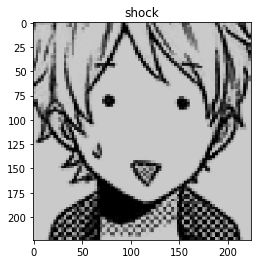

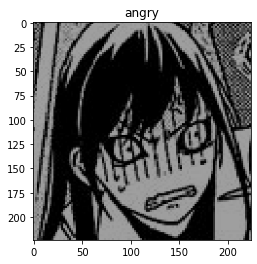

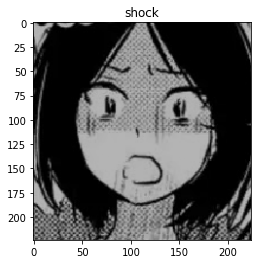

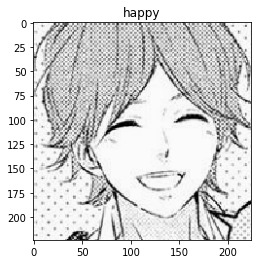

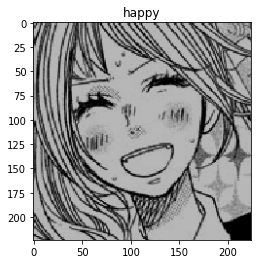

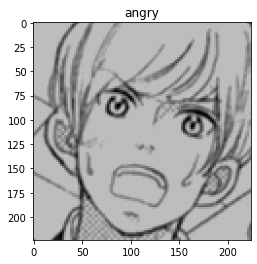

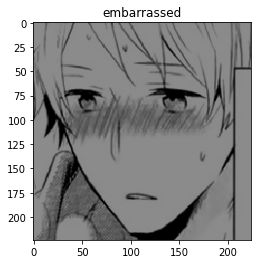

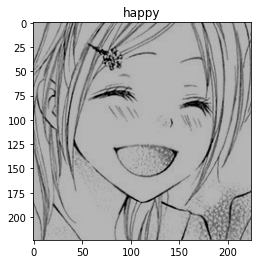

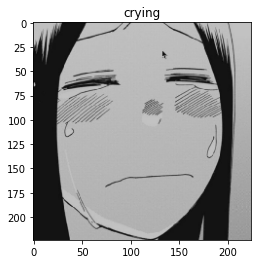

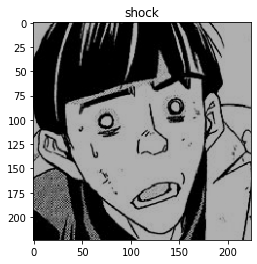

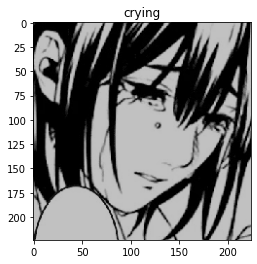

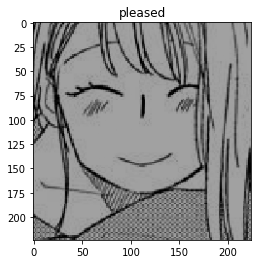

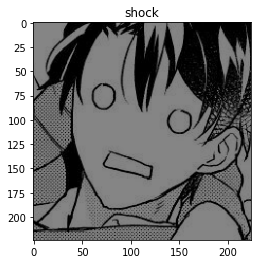

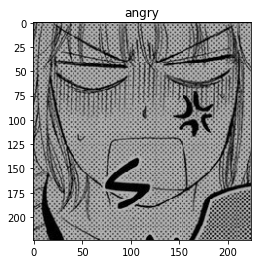

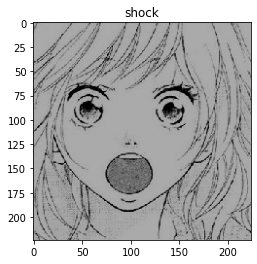

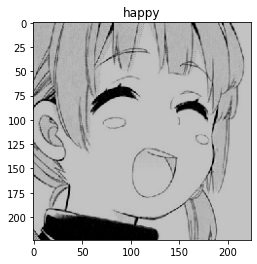

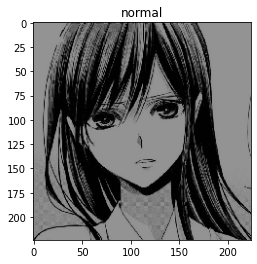

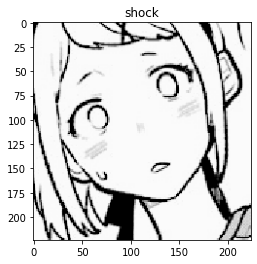

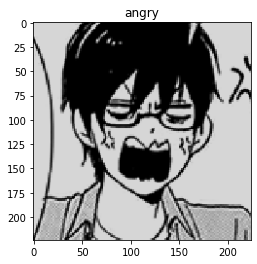

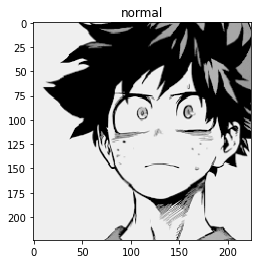

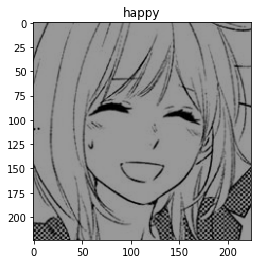

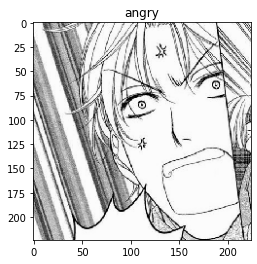

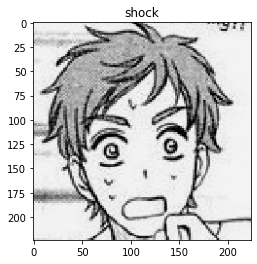

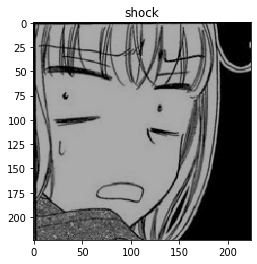

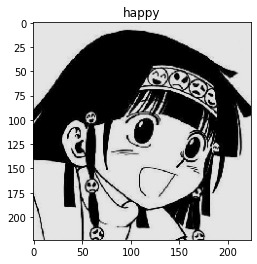

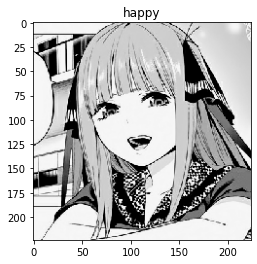

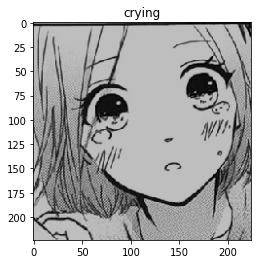

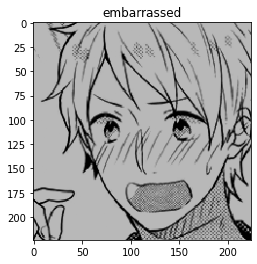

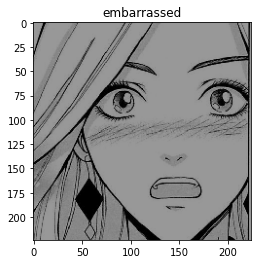

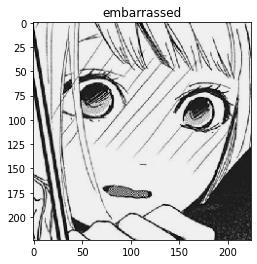

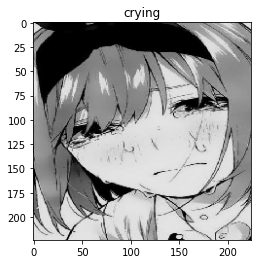

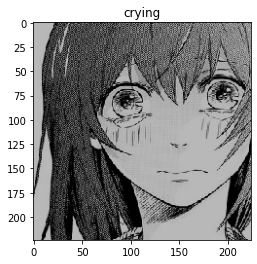

In [ ]:
imgs, labels = next(iter(img_generator_flow_train))
for img, label in zip(imgs, labels):
    value=np.argmax(label)
    plt.imshow(img)
    plt.title(reverse_mapping[value])
    plt.show()

# Part 2 Transfer Learning
Import a pretrained model
 
 โดย model ที่ผมจะนำมาใช้ในวันนี้คือ InceptionV3 
# - https://www.tensorflow.org/api_docs/python/tf/keras/applications/InceptionV3

In [ ]:
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

Set the weights of the imported model

In [ ]:
base_model.trainable = False

In [ ]:
tf.keras.applications.inception_v3.InceptionV3(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

สร้างโมเดลที่สมบูรณ์ของเราโดยเพิ่มเลเยอร์สุดท้ายที่ปรับให้เข้ากับข้อมูลของเรา

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(11, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 2, 2, 2048)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 11)                90123     
                                                                 
Total params: 21,892,907
Trainable params: 90,123
Non-trainable params: 21,802,784
_________________________________________________________________


Compile model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

Train the model

In [ ]:
model.fit(img_generator_flow_train, 
          validation_data=img_generator_flow_valid, 
          steps_per_epoch=10, epochs=20) 

Epoch 1/100
10/10 [==============================] - 57s 5s/step - loss: 2.9086 - categorical_accuracy: 0.1544 - val_loss: 2.5818 - val_categorical_accuracy: 0.2109
Epoch 2/100
10/10 [==============================] - 50s 5s/step - loss: 2.4610 - categorical_accuracy: 0.2483 - val_loss: 2.3798 - val_categorical_accuracy: 0.2721
Epoch 3/100
10/10 [==============================] - 54s 6s/step - loss: 2.0712 - categorical_accuracy: 0.3063 - val_loss: 2.3772 - val_categorical_accuracy: 0.2313
Epoch 4/100
10/10 [==============================] - 49s 5s/step - loss: 1.8771 - categorical_accuracy: 0.3490 - val_loss: 2.2669 - val_categorical_accuracy: 0.3197
Epoch 5/100
10/10 [==============================] - 49s 5s/step - loss: 1.8612 - categorical_accuracy: 0.3792 - val_loss: 2.2219 - val_categorical_accuracy: 0.3061
Epoch 6/100
10/10 [==============================] - 49s 5s/step - loss: 1.6241 - categorical_accuracy: 0.4530 - val_loss: 2.1582 - val_categorical_accuracy: 0.3265
Epoch 7/10

# Visualize accuracy and loss
ตรวจสอบความแม่นยำของ model 

In [ ]:
# Visualise train / Valid Accuracy
plt.plot(model.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

AttributeError: ignored

 ตรวจสอบค่า loss

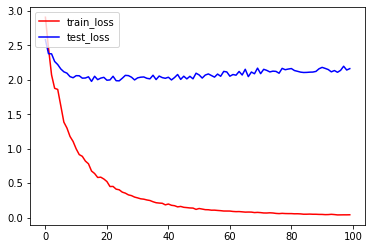

In [ ]:
# Visualise train / Valid Loss
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()


# Part 3 : Interpretation with Grad Cam
- โดยในขั้นตอนสุดท้ายของการตรวจสอบ model ของผมจะใช้ Grad Cam เพื่อ Visualize สิ่งที่โมเดลเห็น และจะได้รู้ว่าที่โมเดลที่ทำนายออกมาเป็นผลลัพธ์ นั้นโมเดลพิจารณาจากจุดไหนของ Data หรือรูปภาพของเราเพื่อที่จะสามารถ
นำไปปรับปรุงข้อมูลในอนาคต โดยเจ้า Grad Cam จะทำงานร่วมกับ heatmap

Create imgs and labels

In [ ]:
imgs, labels = next(iter(img_generator_flow_valid))

In [ ]:
for layer in model.layers:
    print(layer.name)

inception_v3
max_pooling2d_8
flatten
dense


In [ ]:
base_model = model.layers[0]

In [ ]:
last_conv_layer_name = "mixed10"
classifier_layer_names = [layer.name for layer in model.layers][1:]

In [ ]:
# We start by setting up the dependencies we will use

import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

**make_gradcam_heatmap**

In [ ]:
# The Grad-CAM algorithm
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, base_model, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(base_model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

Predict

In [ ]:
# Print what the top predicted class is
preds = model.predict(imgs)
pred_labels = tf.argmax(preds, axis = -1)

print("Prediction output:", preds)
print("Predicted label:", pred_labels)

1/1 [==============================] - 5s 5s/step
Prediction output: [[6.50169849e-02 9.79488622e-03 1.75809018e-05 1.46941338e-02
  9.38976631e-02 5.44662952e-01 1.30953107e-04 1.08999483e-01
  3.89521330e-04 1.49281636e-01 1.31141180e-02]
 [5.21624601e-03 9.29599442e-03 1.37526204e-05 1.17414456e-03
  5.93709061e-03 8.98197532e-01 1.22569807e-04 7.07384348e-02
  2.20532984e-05 2.32841191e-03 6.95377449e-03]
 [2.00907663e-02 1.31141907e-03 1.04249675e-05 3.07863448e-02
  5.40255662e-03 8.49417567e-01 1.26937253e-03 3.33497487e-02
  4.77522466e-04 5.73845319e-02 4.99632326e-04]
 [1.11709097e-02 1.00626482e-03 4.85974306e-06 4.77117039e-02
  2.75411099e-01 1.82416092e-03 4.43209137e-05 7.67561840e-04
  2.73861573e-04 6.50328219e-01 1.14569040e-02]
 [7.49717727e-02 3.80388298e-03 5.66342396e-06 5.65732503e-03
  5.56567684e-02 7.26307213e-01 3.13599245e-03 5.98789006e-02
  1.81792257e-03 1.50312250e-02 5.37332334e-02]
 [8.11284110e-02 1.10186978e-04 3.87201044e-06 4.41122614e-02
  6.24958

**Create heatmap**

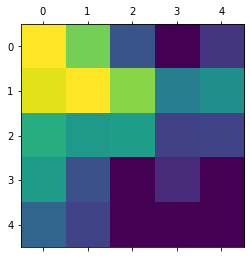

In [ ]:
# Generate class activation heatmap
heatmaps = []

for img in imgs:
    heatmap = make_gradcam_heatmap(
    tf.expand_dims(img,axis=0),
        base_model, model, 
        last_conv_layer_name, 
        classifier_layer_names
  )
    heatmaps.append(heatmap)


# Display heatmap
plt.matshow(heatmaps[0])
plt.show()


Predicted label: happy
True label: crying


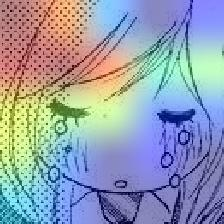

Predicted label: happy
True label: happy


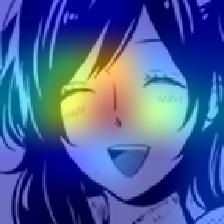

Predicted label: happy
True label: happy


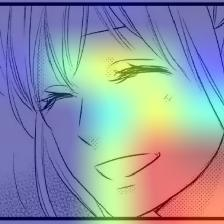

Predicted label: sad
True label: angry


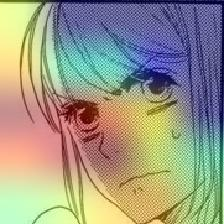

Predicted label: happy
True label: sad


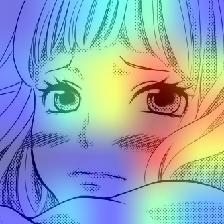

Predicted label: happy
True label: happy


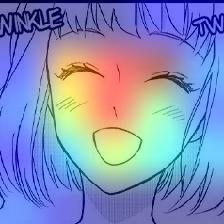

Predicted label: shock
True label: happy


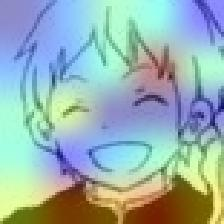

Predicted label: angry
True label: angry


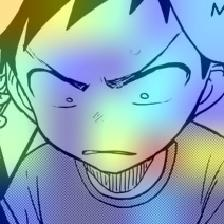

Predicted label: angry
True label: angry


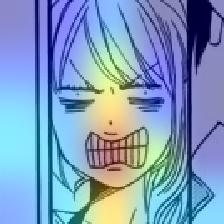

Predicted label: happy
True label: pleased


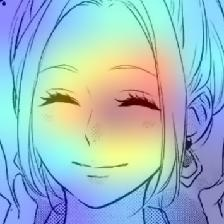

Predicted label: shock
True label: embarrassed


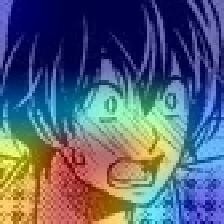

Predicted label: shock
True label: angry


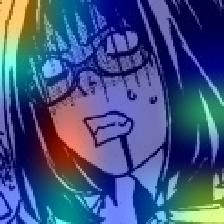

Predicted label: crying
True label: sad


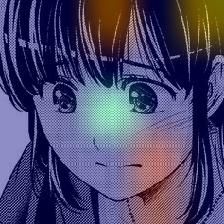

Predicted label: embarrassed
True label: embarrassed


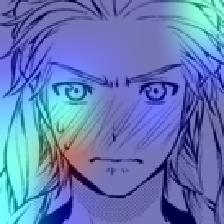

Predicted label: crying
True label: angry


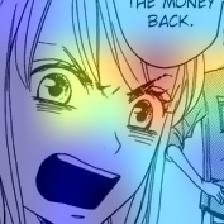

Predicted label: happy
True label: happy


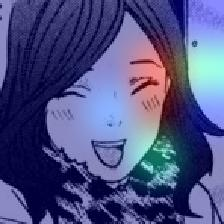

Predicted label: shock
True label: embarrassed


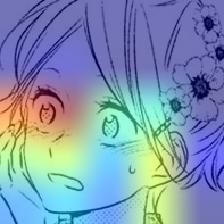

Predicted label: angry
True label: angry


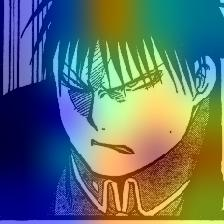

Predicted label: sad
True label: sad


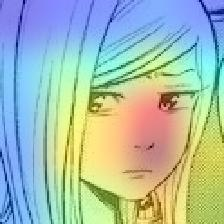

Predicted label: angry
True label: embarrassed


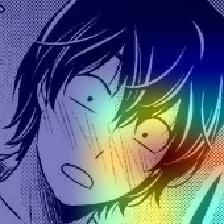

Predicted label: shock
True label: shock


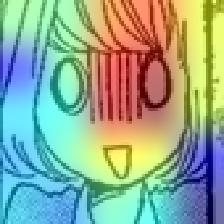

Predicted label: sad
True label: crying


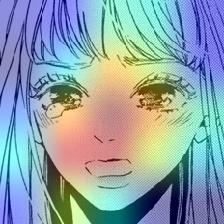

Predicted label: happy
True label: shock


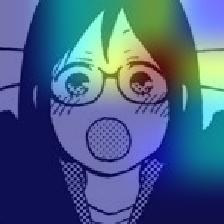

Predicted label: happy
True label: happy


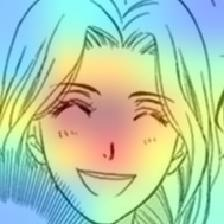

Predicted label: embarrassed
True label: shock


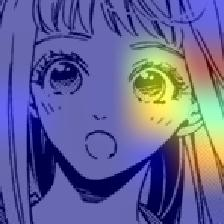

Predicted label: shock
True label: pleased


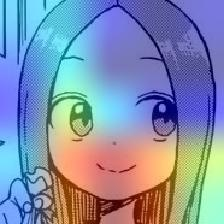

Predicted label: happy
True label: pleased


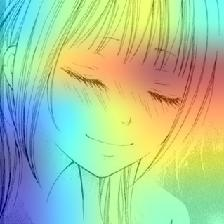

Predicted label: crying
True label: crying


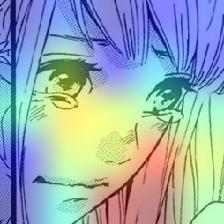

Predicted label: sad
True label: sad


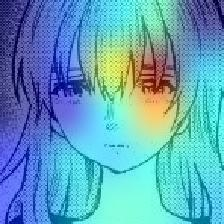

Predicted label: shock
True label: shock


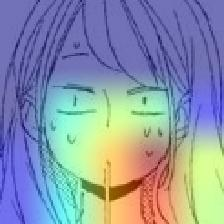

Predicted label: sad
True label: embarrassed


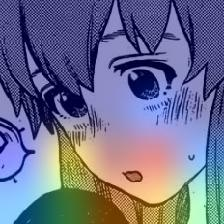

Predicted label: angry
True label: embarrassed


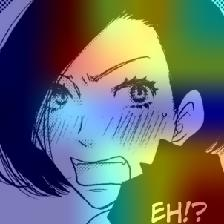

In [ ]:
from pathlib import Path

for img, pred_label, true_label, heatmap in zip(imgs, pred_labels, labels, heatmaps): 
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.003 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    save_path = "saved_img.jpg"
    superimposed_img.save(save_path)

    # Display Grad CAM
    pred_file_path = np.argmax(img_generator_flow_valid.labels == pred_label)
    pred_label_name = Path(img_generator_flow_valid.filepaths[pred_file_path]).parent.name

    true_file_path = np.argmax(img_generator_flow_valid.labels == tf.argmax(true_label))
    true_label_name = Path(img_generator_flow_valid.filepaths[true_file_path]).parent.name

    print("Predicted label:",pred_label_name)
    print("True label:", true_label_name)

    display(Image(save_path))

สุดท้ายแล้วเรามาดูกันดีว่า model ของเรานั้น ทำงานได้ดีแค่ไหน

In [ ]:
LABEL=[]
for item in labels:
    LABEL+=[np.argmax(item)]
print(LABEL)

[3, 5, 5, 0, 9, 5, 5, 0, 0, 7, 4, 0, 9, 4, 0, 5, 4, 0, 9, 4, 10, 3, 10, 5, 10, 7, 7, 3, 9, 10, 4, 4]


In [ ]:
PRED=pred_labels.numpy().tolist()
print(PRED)

[5, 5, 5, 9, 5, 5, 10, 0, 0, 5, 10, 10, 3, 4, 3, 5, 10, 0, 9, 0, 10, 9, 5, 5, 4, 10, 5, 3, 9, 10, 9, 0]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(LABEL, PRED))

              precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           3       0.33      0.33      0.33         3
           4       0.50      0.17      0.25         6
           5       0.50      0.83      0.62         6
           7       0.00      0.00      0.00         3
           9       0.40      0.50      0.44         4
          10       0.29      0.50      0.36         4

    accuracy                           0.44        32
   macro avg       0.37      0.40      0.37        32
weighted avg       0.42      0.44      0.40        32



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


สุดท้ายแล้วตัว model ของกผม นั้นก็มีความแม่นยำถึง 32 % โดยสำหรับผมแล้วตัวของโมเดลถือว่าทำออกมาได้ดีเนื่องจาก ตัวของข้อมูล นั้นยังมีความจำเป็นที่จะต้องจำแนกให้มีให้ประสิทธิภาพ ให้มากยิ่งขึ้นเนื่อง
โดยอุปสรรคหลักของ ของการจำแนกนั้น มีทั้งการไม่ชัดเจนของหน้าตาตัวละคร
หรือแม้กกระทั้งลายเส้นที่แต่ต่างกันออกไปในแต่ละภาพ
